## Acute Lymphoblastic Leukemia Detection
Acute Lymphobastic Leukemia (ALL) is a cancer of the bone marrow and blood, which progresses rapidly without treatment.

The diagnosis of ALL is extremely time-consuming, expensive and difficult.

The use of Peripheral Blood Smear(PBS) for an initial screening of patients, would go a long way, especially in areas with economic difficulties and lack of good medical care. Additionally, these areas generally show a lack of accomplished medical personnel, leading to errors while analyzing PBS images.

Hence, a viable solution is to create a classification model trained on more than 3000 images to predict if cells are malignant or benign.



DISCLAIMER: This is an experimental project, NOT to be used professionally in any way, shape or form.


In [ ]:
!pip install opendatasets --upgrade --quiet

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import opendatasets as od
from torch.utils.data import random_split

from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
dataset_url = 'https://www.kaggle.com/datasets/mohammadamireshraghi/blood-cell-cancer-all-4class'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: avithakur0812
Your Kaggle Key: ··········


100%|██████████| 1.68G/1.68G [00:13<00:00, 132MB/s]


In [ ]:
import os

DATA_DIR = './blood-cell-cancer-all-4class'
DATA_DIR = DATA_DIR + '/Blood cell Cancer [ALL]'
print(os.listdir(DATA_DIR))

['[Malignant] Pro-B', '[Malignant] Pre-B', 'Benign', '[Malignant] early Pre-B']


The dataset contains 4 classes. There's 'Benign', meaning that these groups of cells do not pose any immediate threat of growing and spreading. Malignant cells are the exact opposite and are divided into three parts, '[Malignant] Pro-B', '[Malignant] Pre-B' and '[Malignant] early Pre-B'.

In [ ]:
print(os.listdir(DATA_DIR+'/Benign')[:10])


['Snap_125.jpg', 'Snap_028 (3).jpg', 'Snap_101 (2).jpg', 'Snap_147.jpg', 'Snap_015 (3).jpg', 'Snap_024.jpg', 'Snap_068 (3).jpg', 'Snap_048 (3).jpg', 'Snap_072 (2).jpg', 'Snap_016 (3).jpg']


In [ ]:
ben = len(os.listdir(DATA_DIR+'/Benign'))
pro = len(os.listdir(DATA_DIR+'/[Malignant] Pro-B'))
pre = len(os.listdir(DATA_DIR+'/[Malignant] Pre-B'))
early = len(os.listdir(DATA_DIR+'/[Malignant] early Pre-B'))
print(ben, pro, pre, early)

512 796 955 979


In [ ]:
sample = (DATA_DIR + '/Blood cell Cancer [ALL]/Benign')[0]

In [ ]:
image_files = os.listdir(DATA_DIR)

In [ ]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [ ]:
dataset = ImageFolder(root=DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

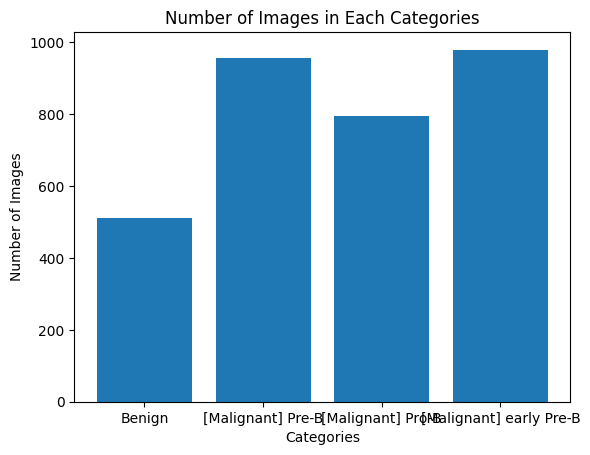

In [ ]:
class_names = dataset.classes
class_counts = ben, pre, pro, early
plt.bar(class_names, class_counts)
plt.xlabel('Categories')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Categories')
plt.show()


In [ ]:
dataset

Dataset ImageFolder
    Number of datapoints: 3242
    Root location: ./blood-cell-cancer-all-4class/Blood cell Cancer [ALL]
    StandardTransform
Transform: Compose(
               Resize(size=64, interpolation=bilinear, max_size=None, antialias=warn)
               CenterCrop(size=(64, 64))
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

The dataset consists of 3242 images in .jpg format.

In [ ]:
train_size = int(0.9 * len(dataset))  # 90% for training
test_size = len(dataset) - train_size  # Remaining 10% for testing
train_ds, test_ds = torch.utils.data.random_split(dataset, [train_size, test_size])
train_size


2917

10% of the images are set apart as the testing dataset, while the rest of the 90% is used for training, but not really, because of the 90%, around 10% which equate to around 300 images, are used for the validation dataset.

In [ ]:
random_seed = 1
torch.manual_seed(random_seed);
val_size = 300
train_size = len(train_ds1) - val_size

train_ds, val_ds = random_split(train_ds1, [train_size, val_size])
len(train_ds), len(val_ds)

(2617, 300)

In [ ]:
#Using the DataLoader to load all our datasets
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size, shuffle=False, num_workers=3, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
train_ds[0][0].shape

torch.Size([3, 64, 64])

In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [ ]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

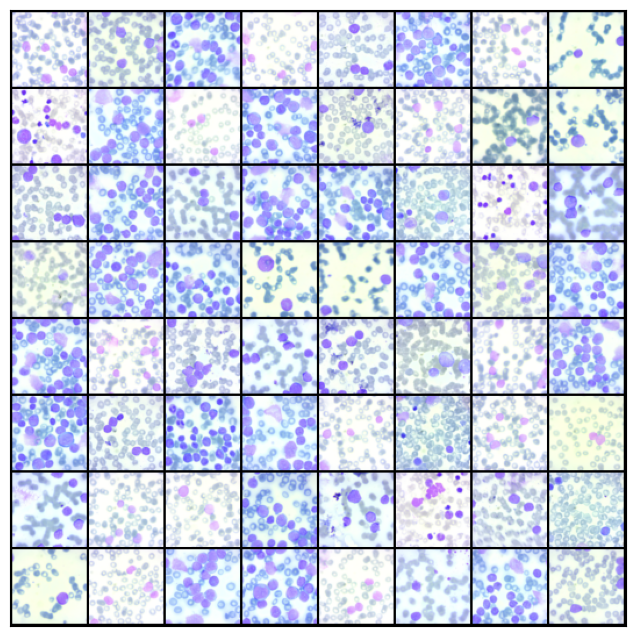

In [ ]:
show_batch(train_dl)

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [ ]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}".format( epoch, result['train_loss']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

The model is a comprised of a series of Convolutional Neural Networks, Batch Normalizing layers, activation functions and pooling layers.

Our input is a 3 channel RGB image, we convolve with a default stride and padding of 1, and a kernel of 3x3. The convolutions happen sequentially and convert the channels into a linear output over time, and many layers.

Batch Normalization is extremely useful, as it solves the problem of internal covariate shift. As we update individual nodes using our error function, we assume that other layers, are constant, ignoring the fact that all layers are continuously changing. Hence, to prevent overfitting, we normalize individual batches using their mean and variance.

We use the LeakyReLU, allowing the passage of a small negative value as the activation function to ensure that our Neural Network undesrtands the non-linear relationships.

Finally, the Max Pooling layer compresses the data.

In [ ]:
class ALLClassifier(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(2, 2), 
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(2, 2), 

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Flatten(), 
            nn.Linear(256*8*8, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 4)
            )
        
    def forward(self, xb):
        return self.network(xb)

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)
to_device(model, device);

In [ ]:
model = ALLClassifier()
model

ALLClassifier(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slope=0.2, inplace=True)
 

In [ ]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([128, 3, 64, 64])
out.shape: torch.Size([128, 4])
out[0]: tensor([ 0.1551, -0.0103,  0.0824,  0.0213], device='cuda:0',
       grad_fn=<SelectBackward0>)


The output is of the shape (128, 4), representing the 4 classes of our dataset.

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
model = to_device(ALLClassifier(), device)

In [ ]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

We train our dataset for 10 epochs, with a relatively low learning rate using the Adam Optimizer.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 2.8179
Epoch [1], train_loss: 0.6030
Epoch [2], train_loss: 0.3651
Epoch [3], train_loss: 0.3080
Epoch [4], train_loss: 0.1758
Epoch [5], train_loss: 0.1303
Epoch [6], train_loss: 0.1012
Epoch [7], train_loss: 0.0765
Epoch [8], train_loss: 0.1072
Epoch [9], train_loss: 0.0891


In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

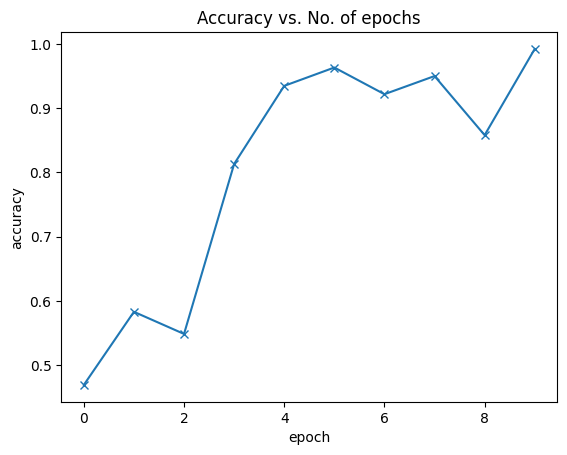

In [ ]:
plot_accuracies(history)

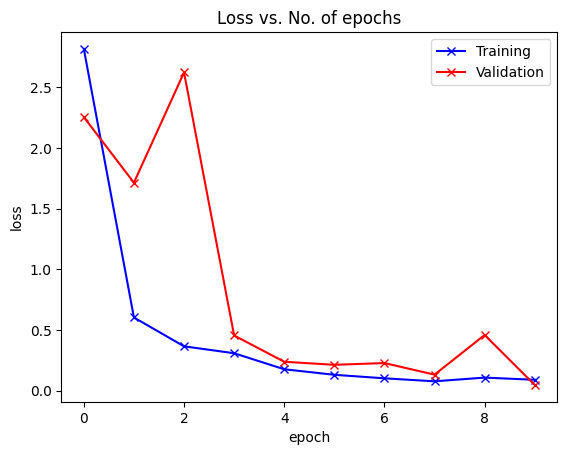

In [ ]:
plot_losses(history)

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Label: [Malignant] early Pre-B , Predicted: [Malignant] early Pre-B


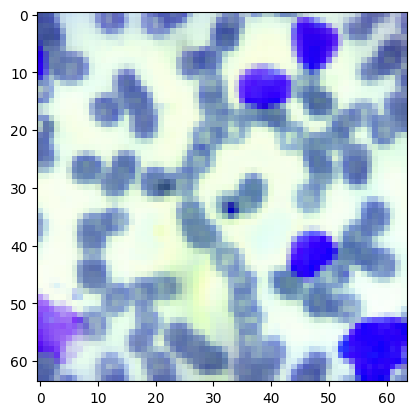

In [ ]:
img, label = test_ds[100]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [ ]:
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [ ]:
result = evaluate(model, test_dl)
result

{'val_loss': 0.05897526070475578, 'val_acc': 0.9769399166107178}

Our model ends up with a very respectable accuracy of 97.6%